In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
from glob import glob
from tips.io import load_ds

def unique_legend(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), **kwargs)

In [2]:
exp = '../exp/prod-adam-run2/'

In [3]:
logs = glob(f'{exp}/models/gen*/model1/pinn.log')
gen = [int(re.search('gen(\d+)', l)[1]) for l in logs]
err = [np.loadtxt(l)[-1] for l in logs]
logs = np.array([[g,*e] for  g, e in zip(gen, err)])
pinn_logs = logs[logs[:,0].argsort()]

In [4]:
logs = glob(f'{exp}/emd/gen*/m0i32-r1.08/asemd.log')
gen = [int(re.search('gen(\d+)', l)[1]) for l in logs]
scale = [np.loadtxt(l, skiprows=1)[-1,0] for l in logs]
logs = np.array([*zip(gen,scale)])
md_logs = logs[logs[:,0].argsort()]

In [5]:
natom = 640
logs = glob(f'{exp}/emd/gen*/m0i32-r1.08/asemd.log')
gen = sorted([int(re.search('gen(\d+)', l)[1]) for l in logs])
f_rmse, e_rmse = [], []
for g in gen:
    e_se = []
    f_se = []
    for fidx in glob(f'{exp}/merge/gen{g}/*/merged.idx'):
        idx = np.loadtxt(fidx, int)
        isort = np.argsort(idx)
        init = re.search('gen\d+/(.*)/merged.idx', fidx)[1]
        label = load_ds(f'{exp}/merge/gen{g}/{init}/merged.traj', fmt='asetraj')
        e_label = np.array([l['energy'] for l in label])[isort] / natom
        f_label = np.array([l['force'] for l in label])[isort]
        ftraj = f'{exp}/emd/gen{g}/{init}/asemd.traj'
        traj = load_ds(ftraj, fmt='asetraj', index=f':{idx[isort[-1]]+1}:{idx[isort[1]]}')
        e_model = np.array([datum['energy'] for datum in traj]) / natom
        f_model = np.array([datum['force'] for datum in traj])
        e_se.append(np.mean((e_model-e_label)**2))
        f_se.append(np.mean((f_model-f_label)**2))
    f_rmse.append(np.sqrt(np.mean(f_se))*1e3)
    e_rmse.append(np.sqrt(np.mean(e_se))*1e3)

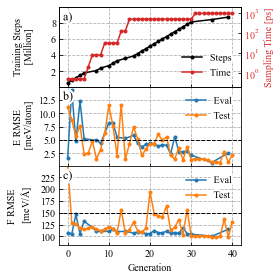

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[4,4], 
                                  sharex=True, 
                                  gridspec_kw={'hspace':0})
tax = ax1.twinx()


l1, = ax1.plot(pinn_logs[:,0], pinn_logs[:,1]/1e6, 'k.-')
l2, = tax.plot(md_logs[:,0], md_logs[:,1], '.-', color='tab:red')
l3, = ax2.plot(pinn_logs[:,0], pinn_logs[:,2]*1e3, '.-')
l4, = ax2.plot(gen, e_rmse, '.-')
l5, = ax3.plot(pinn_logs[:,0], pinn_logs[:,4]*1e3, '.-')
l6, = ax3.plot(gen, f_rmse, '.-')

ax2.plot([-10,50], [5,5], 'k--', lw=1)
ax3.plot([-10,50], [150,150], 'k--', lw=1)

ax1.grid()
ax2.grid()
ax3.grid()

tax.set_yscale('log')
ax1.set_ylabel('Training Steps\n [Million]')
ax2.set_ylabel('E RMSE\n [meV/atom]')
ax3.set_ylabel('F RMSE\n [meV/$\AA$]')
ax3.set_xlabel('Generation')
tax.tick_params(axis='y', labelcolor='tab:red')
tax.set_ylabel('Sampling Time [ps]', color='tab:red')
ax1.set_yticks(np.arange(0,11,2))
ax2.set_yticks(np.arange(0,15,2.5))
ax3.set_yticks(np.arange(100,250,25))
tax.set_yticks([1e0, 1e1, 1e2, 1e3])
ax1.set_xlim(-2,42)
ax1.set_ylim(0.1,9.9)
ax2.set_ylim(0.1,15)
ax3.set_ylim(81,249)
tax.set_ylim(2e-1,2e3)

leg1 = ax1.legend([l1, l2], ['Steps', 'Time'], loc=4)
leg2 = ax2.legend([l3, l4], ['Eval', 'Test'],)
leg3 = ax3.legend([l5, l6], ['Eval', 'Test'], )

mype = [pe.withStroke(linewidth=4, foreground='w')]
for leg in [leg1, leg2, leg3]:
    for t in leg.get_texts():
        t.set_path_effects(mype)

for label, ax in zip('abc', (ax1, ax2, ax3)):
    t = ax.text(0.02,0.95, f'{label})', transform=ax.transAxes, va='top',
                fontsize=12)
    t.set_path_effects(mype)
        
f.align_ylabels()
plt.tight_layout()
plt.savefig(f'figs/fig1-logs-{exp.split("/")[-2]}.png')